# **Custom Learning Rate Scheduler**

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 0.1017 - lr: 0.1000
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0832 - lr: 0.1000
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0820 - lr: 0.1000
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0823 - lr: 0.1000
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0827 - lr: 0.1000
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0833 - lr: 0.1000
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0827 - lr: 0.1000
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0825 - lr: 0.1000
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0833 - lr: 0.1000
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0838 - lr: 0.1000
Epoch 11/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0827

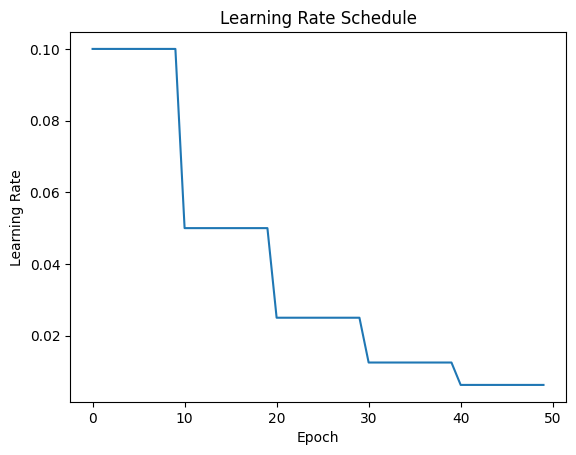

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Generate synthetic data
np.random.seed(0)
x_train = np.random.random((1000, 10))
y_train = np.random.random((1000, 1))

def step_decay_schedule(initial_lr, decay_factor, step_size):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** (epoch // step_size))
        return new_lr

    return keras.callbacks.LearningRateScheduler(schedule)

# Model definition
model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    keras.layers.Dense(1)
])

# Compile model
initial_learning_rate = 0.1
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

# Training parameters
epochs = 50
decay_factor = 0.5
step_size = 10

# Include the learning rate scheduler callback
lr_scheduler = step_decay_schedule(initial_lr=initial_learning_rate,
                                   decay_factor=decay_factor, step_size=step_size)

# Train model
history = model.fit(x_train, y_train, epochs=epochs, callbacks=[lr_scheduler])

# Optionally, plot the learning rate progress
import matplotlib.pyplot as plt

plt.plot(history.history['lr'])
plt.title('Learning Rate Schedule')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.show()


# **custom dropout layer**

In [ ]:
import tensorflow as tf
from tensorflow import keras

class VariableDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(VariableDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            if training:
                return tf.nn.dropout(inputs, rate=self.rate)
            return inputs
        return inputs

# Model definition using the custom dropout
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    VariableDropout(rate=0.5),
    keras.layers.Dense(1)
])

# Generate synthetic data
import numpy as np
np.random.seed(0)
x_train = np.random.random((1000, 10))
y_train = np.random.random((1000, 1))

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=30)

# Optionally, evaluate the model
loss = model.evaluate(x_train, y_train)
print("Loss:", loss)


Epoch 1/30
32/32 [==============================] - 2s 6ms/step - loss: 0.2412
Epoch 2/30
32/32 [==============================] - 0s 4ms/step - loss: 0.1759
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.1423
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.1237
Epoch 5/30
32/32 [==============================] - 0s 4ms/step - loss: 0.1123
Epoch 6/30
32/32 [==============================] - 0s 4ms/step - loss: 0.1068
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 0.1060
Epoch 8/30
32/32 [==============================] - 0s 4ms/step - loss: 0.1052
Epoch 9/30
32/32 [==============================] - 0s 2ms/step - loss: 0.0954
Epoch 10/30
32/32 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 11/30
32/32 [==============================] - 0s 2ms/step - loss: 0.0931
Epoch 12/30
32/32 [==============================] - 0s 2ms/step - loss: 0.0980
Epoch 13/30
32/32 [==============================

# **Batch Normalization**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class BatchRenormalization(keras.layers.Layer):
    def __init__(self, momentum=0.99, epsilon=1e-3):
        super(BatchRenormalization, self).__init__()
        self.momentum = momentum
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.running_mean = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=False)
        self.running_variance = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=False)

    def call(self, inputs, training=None):
        if training:
            mean, variance = tf.nn.moments(inputs, axes=[0, 1, 2], keepdims=False)
            self.running_mean.assign(self.momentum * self.running_mean + (1 - self.momentum) * mean)
            self.running_variance.assign(self.momentum * self.running_variance + (1 - self.momentum) * variance)
            normed = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        else:
            normed = (inputs - self.running_mean) / tf.sqrt(self.running_variance + self.epsilon)
        return self.gamma * normed + self.beta

# Generate synthetic data
x_train = np.random.rand(1000, 28, 28, 1).astype('float32')  # 1000 samples of 28x28 pixels, grayscale images
y_train = np.random.randint(0, 10, size=(1000,)).astype('int32')  # 1000 labels for 10 classes

# Example of using the Batch Renormalization layer in a model
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    BatchRenormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10)

# Optionally, evaluate the model
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
32/32 [==============================] - 4s 47ms/step - loss: 3.1276 - accuracy: 0.1080
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 2.0896 - accuracy: 0.2680
Epoch 3/10
32/32 [==============================] - 1s 30ms/step - loss: 1.2953 - accuracy: 0.5930
Epoch 4/10
32/32 [==============================] - 1s 29ms/step - loss: 0.6102 - accuracy: 0.8950
Epoch 5/10
32/32 [==============================] - 1s 27ms/step - loss: 0.2674 - accuracy: 0.9860
Epoch 6/10
32/32 [==============================] - 1s 28ms/step - loss: 0.1254 - accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 1s 28ms/step - loss: 0.0694 - accuracy: 1.0000
Epoch 8/10
32/32 [==============================] - 1s 29ms/step - loss: 0.0462 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0343 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 0s 7ms/step - loss: 1.1379 - accuracy: 1.0000
Metrics: [

# **Custom dropout**

In [ ]:
import tensorflow as tf
from tensorflow import keras

class CustomDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            noise_shape = (tf.shape(inputs)[0], 1, 1, tf.shape(inputs)[3])
            return tf.nn.dropout(inputs, rate=self.rate, noise_shape=noise_shape)
        return inputs

# Example of using the Custom Dropout layer in a model
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    CustomDropout(0.5),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

# Generate synthetic data
x_train = np.random.rand(1000, 28, 28, 1).astype('float32')  # 1000 samples of 28x28 pixels, grayscale images
y_train = np.random.randint(0, 10, size=(1000,)).astype('int32')  # 1000 labels for 10 classes

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10)

# Optionally, evaluate the model
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
32/32 [==============================] - 1s 16ms/step - loss: 2.3701 - accuracy: 0.1130
Epoch 2/10
32/32 [==============================] - 1s 15ms/step - loss: 2.2933 - accuracy: 0.1140
Epoch 3/10
32/32 [==============================] - 0s 15ms/step - loss: 2.2597 - accuracy: 0.1690
Epoch 4/10
32/32 [==============================] - 1s 16ms/step - loss: 2.2130 - accuracy: 0.2470
Epoch 5/10
32/32 [==============================] - 0s 15ms/step - loss: 2.1647 - accuracy: 0.2400
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 2.1081 - accuracy: 0.3410
Epoch 7/10
32/32 [==============================] - 0s 15ms/step - loss: 2.0296 - accuracy: 0.3820
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 1.9753 - accuracy: 0.4060
Epoch 9/10
32/32 [==============================] - 0s 15ms/step - loss: 1.9148 - accuracy: 0.4450
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 1.6950 - accuracy: 0.8070
Metrics: [

# **Custom Loss Function: Huber Loss**

In [ ]:
import tensorflow as tf
from tensorflow import keras

class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0):
        super(HuberLoss, self).__init__()
        self.threshold = threshold

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * (tf.abs(error) - self.threshold / 2)
        return tf.where(is_small_error, squared_loss, linear_loss)

# Example of using the custom Huber loss in a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss=HuberLoss(2.0))

# Generate synthetic data
x_train = tf.random.normal((100, 10))
y_train = 2 * x_train[:, 0] + 3 * x_train[:, 1] + 1 + tf.random.normal((100,))

# Train the model
history = model.fit(x_train, y_train, epochs=10, verbose=1)

# Optionally, evaluate the model
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 4.9081
Epoch 2/10
4/4 [==============================] - 0s 5ms/step - loss: 4.8121
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 4.7286
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 4.6462
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 4.5709
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 4.4952
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 4.4131
Epoch 8/10
4/4 [==============================] - 0s 5ms/step - loss: 4.3379
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 4.2588
Epoch 10/10
4/4 [==============================] - 0s 6ms/step - loss: 4.1169
Metrics: 4.116886615753174


# **Custom Activation Function: Parametric SoftPlus**

In [ ]:
import tensorflow as tf
from tensorflow import keras

class ParametricSoftPlus(keras.layers.Layer):
    def __init__(self, beta=1.0):
        super(ParametricSoftPlus, self).__init__()
        self.beta = beta  # Parameter to control the steepness

    def call(self, inputs):
        return tf.math.log(1.0 + tf.math.exp(self.beta * inputs))

# Example of using the custom Parametric SoftPlus activation in a model
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(10,)),
    ParametricSoftPlus(beta=0.5),  # Using a custom activation function
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Generate synthetic data
x_train = tf.random.normal((100, 10))
y_train = 2 * x_train[:, 0] + 3 * x_train[:, 1] + 1 + tf.random.normal((100,))

# Train the model
history = model.fit(x_train, y_train, epochs=10, verbose=1)

# Optionally, evaluate the model
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 13.0747
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 12.8824
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 12.7200
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 12.5411
Epoch 5/10
4/4 [==============================] - 0s 6ms/step - loss: 12.4179
Epoch 6/10
4/4 [==============================] - 0s 6ms/step - loss: 12.2730
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 12.1469
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 12.0085
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 11.9244
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 11.6863
Metrics: 11.686280250549316


# **Custom Initializer: Random Normal Multiplier**

In [ ]:
class RandomNormalMultiplier(keras.initializers.Initializer):
    def __init__(self, mean=0.0, stddev=0.05, multiplier=1.0):
        self.mean = mean
        self.stddev = stddev
        self.multiplier = multiplier

    def __call__(self, shape, dtype=None):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype) * self.multiplier

    def get_config(self):
        return {'mean': self.mean, 'stddev': self.stddev, 'multiplier': self.multiplier}


# **Custom Regularizer: L2 Regularization with Scaling**

In [ ]:
class L2RegularizerWithScale(keras.regularizers.Regularizer):
    def __init__(self, scale=0.01):
        self.scale = scale

    def __call__(self, x):
        return self.scale * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'scale': self.scale}


# **Using Custom Initializer and Regularizer in a Model**

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(10,),
                       kernel_initializer=RandomNormalMultiplier(multiplier=2.0),
                       kernel_regularizer=L2RegularizerWithScale(scale=0.02)),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Generate synthetic data
x_train = tf.random.normal((100, 10))
y_train = 2 * x_train[:, 0] + 3 * x_train[:, 1] + 1 + tf.random.normal((100,))

# Train the model
history = model.fit(x_train, y_train, epochs=10, verbose=1)

# Optionally, evaluate the model
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 14.4623
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 14.0040
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 13.6130
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 13.2286
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 12.8613
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 12.4864
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 12.1157
Epoch 8/10
4/4 [==============================] - 0s 5ms/step - loss: 11.7722
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 11.4487
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 10.8870
Metrics: 10.887018203735352


# **Custom Metric: Precision**

In [ ]:
class Precision(keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_pos = tf.equal(y_true, 1) & tf.equal(y_pred, 1)
        true_pos = tf.cast(true_pos, self.dtype)
        pred_pos = tf.cast(tf.equal(y_pred, 1), self.dtype)

        self.true_positives.assign_add(tf.reduce_sum(true_pos))
        self.predicted_positives.assign_add(tf.reduce_sum(pred_pos))

    def result(self):
        precision = self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())
        return precision

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)


## **Using the Custom Metric in a Model**

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

# Generate synthetic binary classification data
x_train = tf.random.normal((100, 10))
y_train = tf.cast(tf.random.uniform((100,)) > 0.5, tf.float32)

# Train the model
history = model.fit(x_train, y_train, epochs=10, verbose=1)

# Optionally, evaluate the model using custom precision metric
metrics = model.evaluate(x_train, y_train)
print("Metrics:", metrics)


Epoch 1/10
4/4 [==============================] - 1s 7ms/step - loss: 0.7881 - precision: 0.4474
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7809 - precision: 0.4474
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7753 - precision: 0.4595
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7703 - precision: 0.4595
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7656 - precision: 0.4595
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7613 - precision: 0.4595
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.7575 - precision: 0.4737
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7538 - precision: 0.4737
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7502 - precision: 0.4737
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric Precision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


4/4 [==============================] - 0s 5ms/step - loss: 0.7439 - precision: 0.4737
Metrics: [0.7439082860946655, 0.4736842215061188]
